In [12]:
%matplotlib inline

In [499]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.xarray

sns.set(style='ticks', context='paper', palette='colorblind',font_scale=1.3)
mpl.rc('figure', dpi=100, figsize=[11, 5])
mpl.rc('savefig', dpi=500, bbox='tight')
mpl.rc('legend', frameon=False)

import warnings

warnings.simplefilter('ignore')

In [180]:
dat = xr.open_mfdataset('combinations_lt_10_*.nc',concat_dim='clusters',)

In [ ]:
cilow = dat.vort.rolling({'time':periods},center=True).mean().reduce(ci)

/usr/local/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/anaconda3/lib/python3.7/site-packages/dask/array/numpy_compat.py:41: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5, 0, '')

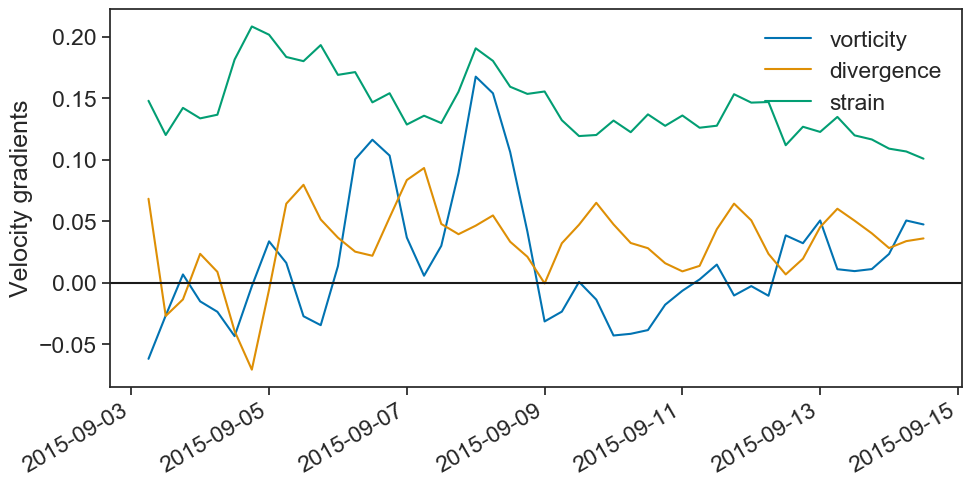

In [217]:
periods=3
dat.vort.rolling({'time':periods},center=True).mean().mean(axis=0).plot(label='vorticity')
dat.div.rolling({'time':periods},center=True).mean().mean(axis=0).plot(label='divergence')
dat.strain.rolling({'time':periods},center=True).mean().mean(axis=0).plot(label='strain')

# dat.vort.mean(axis=0).plot(label='vorticity')
# dat.div.mean(axis=0).plot(label='divergence')
# dat.strain.mean(axis=0).plot(label='strain')
plt.legend()
plt.axhline(0,color='k')
plt.ylabel('Velocity gradients')
plt.xlabel(None)

In [184]:
dat['absvort'] = np.sqrt( dat.vort**2 )
dat['absdiv'] = np.sqrt( dat.div**2 )

In [202]:
grouped = dat.groupby_bins(dat.length,np.logspace(0,2,60)).mean()

/usr/local/anaconda3/lib/python3.7/site-packages/xarray/core/groupby.py:758: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  allow_lazy=True, **kwargs)


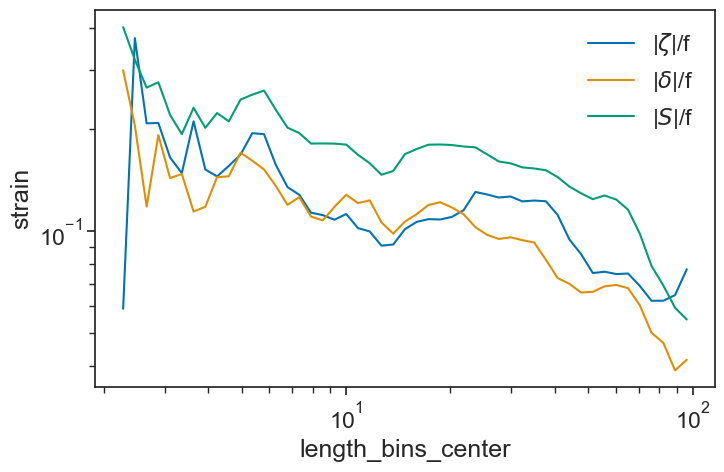

In [203]:
plt.figure(figsize=(8,5))
grouped.absvort.plot(label=r'|$\zeta$|/f')
grouped.absdiv.plot(label=r'|$\delta$|/f')
grouped.strain.plot(label=r'|$S$|/f')
# plt.plot(np.linspace(4,15),(np.linspace(4,15))**-1, color='k', lw=1)
# plt.plot(np.linspace(15,80),(0.2*np.linspace(15,80))**-1, color='k',lw=1)
plt.xscale('log')
plt.yscale('log')
plt.legend()

In [403]:
datm = dat.mean(dim='id')

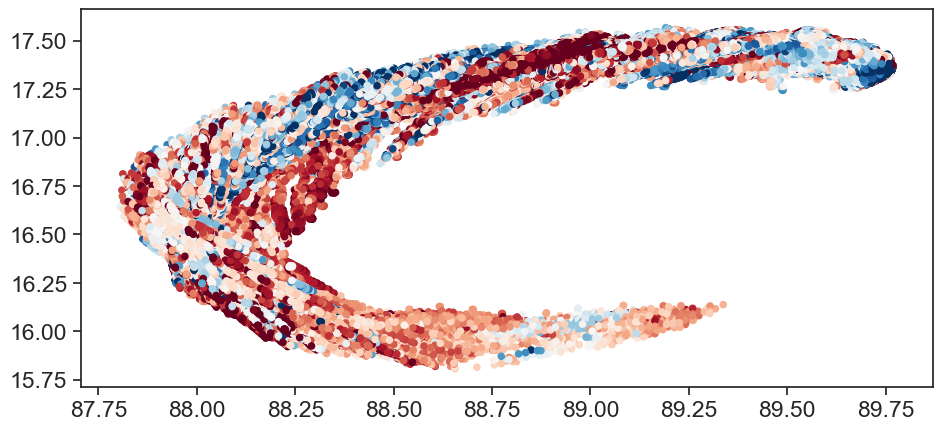

In [248]:
cl = 1
plt.scatter(datm.lon, datm.lat,1,
            datm.vort,vmin=-0.2,vmax=0.2, cmap='RdBu_r', rasterized=True);

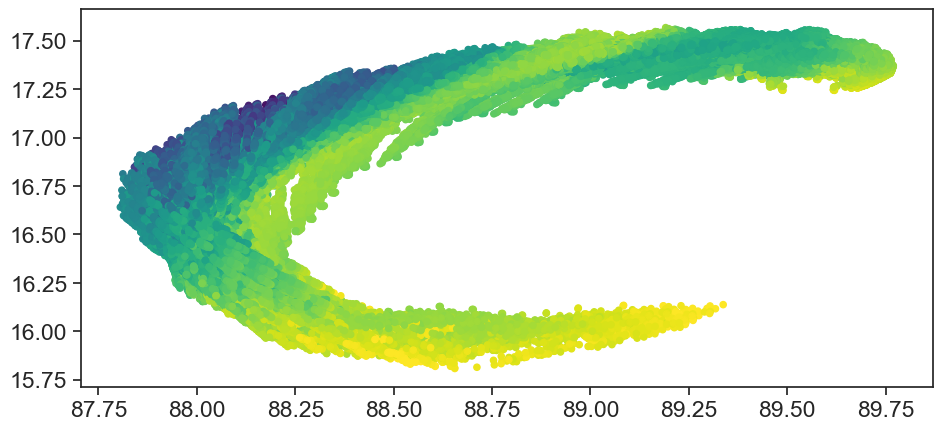

In [249]:
plt.scatter(datm.lon, datm.lat,1,
            datm.sal,vmin=27,vmax=31, cmap='viridis',rasterized=True);

In [470]:
datm = datm.sel(time=slice('2015-09-07','2015-09-14'))
datm['sigma'] =  (('clusters','time'),gsw.density.rho(datm.sal,datm.sst,0)-1000)

In [475]:
def grid_da(xi,yi,array,method='linear'):
    ''' Grid cluster data onto regular grid
    '''
    from scipy.interpolate import griddata

    lon = datm.lon.values.flatten()
    lat = datm.lat.values.flatten()
    ar = datm[array].values.flatten()

    mask = np.isfinite(lon) & np.isfinite(lat) & np.isfinite(ar)
    lon = lon[mask]
    lat = lat[mask]
    ar = ar[mask]
    
    zi = griddata((lon, lat), ar, (xi[None,:], yi[:,None]), method=method )
    return zi

In [456]:
import gsw
import cmocean.cm as cm

In [476]:
xi = np.linspace(87.75,89.5, 100)
yi = np.linspace(15.75,17.5, 100)
zsigma = grid_da(xi,yi,'sigma')
zvort = grid_da(xi,yi,'vort')
zstrain = grid_da(xi,yi,'strain')
zdiv = grid_da(xi,yi,'div')

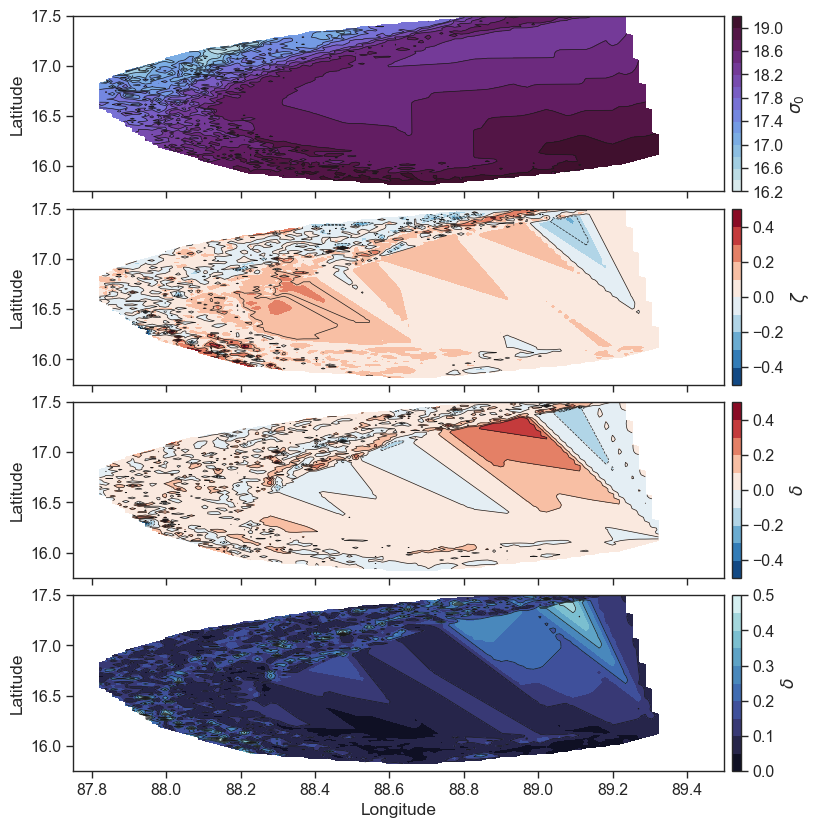

In [518]:
f,axs = plt.subplots(4,1,figsize=(10,10), sharex=True)

axs[0].contour(xi,yi,zsigma,15,linewidths=0.5,colors='k')
h = axs[0].contourf(xi,yi,zsigma,15, cmap=cm.dense)
plt.colorbar(h, ax=axs[0], pad=0.01, label='$\sigma_0$') # draw colorbar
axs[0].set_ylabel('Latitude')

axs[1].contour(xi,yi,zvort,15,linewidths=0.5,colors='k')
levels = np.linspace(-0.5,0.5,11)
h = axs[1].contourf(xi,yi,zvort,15, cmap='RdBu_r', levels=levels)
plt.colorbar(h, ax=axs[1], pad=0.01, label='$\zeta$') # draw colorbar
axs[1].set_ylabel('Latitude')

axs[2].contour(xi,yi,zdiv,15,linewidths=0.5,colors='k')
levels = np.linspace(-0.5,0.5,11)
h = axs[2].contourf(xi,yi,zdiv,15, cmap='RdBu_r', levels=levels)
plt.colorbar(h, ax=axs[2], pad=0.01, label='$\delta$') # draw colorbar
axs[2].set_ylabel('Latitude')

axs[3].contour(xi,yi,zstrain,15,linewidths=0.5,colors='k')
levels = np.linspace(0,0.5,11)
h = axs[3].contourf(xi,yi,zstrain,15, cmap=cm.ice, levels=levels)
plt.colorbar(h, ax=axs[3], pad=0.01, label='$\delta$') # draw colorbar
axs[3].set_ylabel('Latitude')

axs[-1].set_xlabel('Longitude')
plt.subplots_adjust(hspace=0.1)